## Imports

In [212]:
#!pip install -U dill==0.3.5.1
#!pip install -U tensorflow-io==0.27.0
#!pip install -U tensorflow-transform==1.11.0
#!pip install -U tensorflow==2.10.0
import tensorflow as tf
print(tf.__version__)

2.6.4


In [213]:
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings

In [214]:
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

plt.rc('font', size=16)

tfk = tf.keras
tfkl = tf.keras.layers

## Defines

### Seed

In [215]:
# Random seed for reproducibility
seed = 1337

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Constants

#### Imports

In [216]:
dataset_location = '/kaggle/input/training-dataset-homework2/'
x_name = 'x_train.npy'
y_name = 'y_train.npy'

#### Training

In [217]:
classes = 12
input_shape = (36, 6)

batch_size = 64
epochs = 200

label_mapping = {
    "Wish" : 0,
    "Another" : 1,
    "Comfortably" : 2,
    "Money" : 3,
    "Breathe" : 4,
    "Time" : 5,
    "Brain" : 6,
    "Echoes" : 7,
    "Wearing" : 8,
    "Sorrow" : 9,
    "Hey" : 10,
    "Shine" : 11
}

### Utility Functions

In [218]:
def build_sequences(df, window=200, stride=200):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for id in df['id'].unique():
        # Take only meaningful features
        temp = df[df['id'] == id][['x_axis','y_axis','z_axis']].values
        # Save the label
        label = df[df['id'] == id]['activity'].values[0]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,3), dtype='float64')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [219]:
def inspect_multivariate(x, y, idx=None):
    if(idx == None):
        idx = np.random.randint(0, len(x))
    print(f"{y[idx]} --> {np.argmax(y[idx])}")
    df = pd.DataFrame(x[idx,:,:])
    df.plot(subplots=True, figsize=(17, 9))
    plt.show()

In [220]:
def inspect_timewise(total):
    vis = np.transpose(np.concatenate(total))
    plt.rcParams["figure.figsize"] = [15, 30]
    plt.rcParams["figure.autolayout"] = True
    fig, axs = plt.subplots(6)
    for idx in range(6):
        df = pd.DataFrame(vis[idx,:])
        axs[idx].plot(df)
        l=0
        for i in label_counts:
            l = l + i*36
            axs[idx].axvline(l, color='red')
        axs[idx].text(s = f"Feature {idx+1}", x = 80000, y = 30000)
    plt.show()

In [221]:
def evaluate_classes_performance(model, x_val, y_val):
    data_list = []
    label_list = []
    batch_index = 0

    data_array = np.array(x_val)
    label_array = np.array(y_val)   
    label_values = np.argmax(label_array, axis=1)
    predictions = model.predict(data_array)
    predictions_label = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions_label)
    print(report)
    
    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

In [222]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

## Load dataset

In [223]:
x_total = np.load(dataset_location + x_name)
y_total = np.load(dataset_location + y_name)

### Preprocessing

In [224]:
# Weight classes
class_weights = {}
_, label_counts = np.unique(y_total, return_counts=True)
class_mean = sum(label_counts) / len(label_counts)
for i, n in enumerate(label_counts):
    class_weights[i] = (1 / n) * class_mean
print(class_weights)

{0: 5.953431372549019, 1: 1.6456639566395665, 2: 0.7496913580246913, 3: 0.5312773403324584, 4: 3.264784946236559, 5: 1.3229847494553377, 6: 0.6466986155484558, 7: 2.9767156862745097, 8: 1.6868055555555554, 9: 0.2605105105105105, 10: 2.628787878787879, 11: 3.9689542483660127}


In [225]:
x_train, x_val, y_train, y_val = train_test_split(
    x_total,
    y_total,
    test_size=0.2,
    random_state=seed
)

In [226]:
# Norm on the 36-dimension
# x_val /= np.max(np.abs(x_train), axis=0)
# x_train /= np.max(np.abs(x_train), axis=0)

# Norm on the 6-dimension
# x_val /= np.max(np.max(np.abs(x_train), axis=0))
# x_train /= np.max(np.max(np.abs(x_train), axis=0))

In [227]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

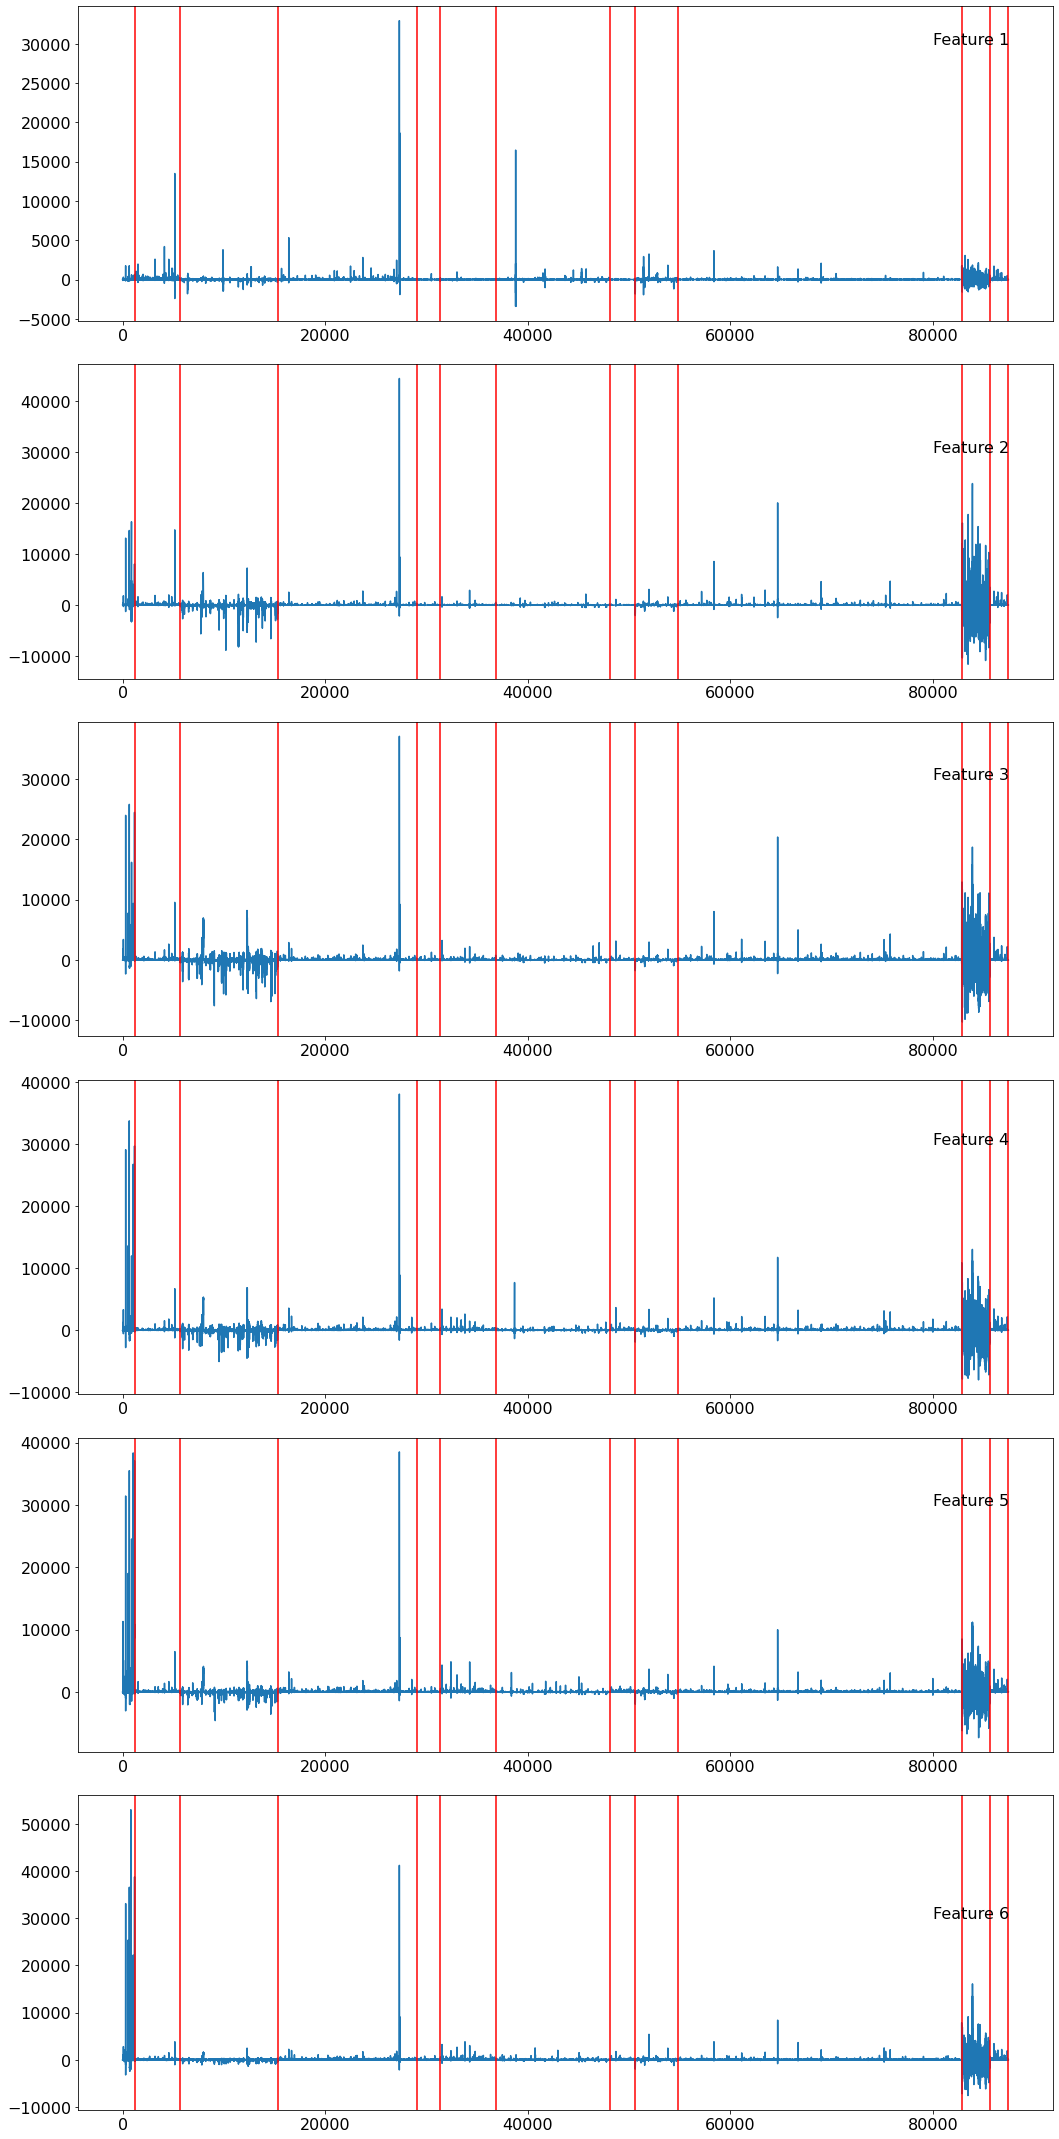

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] --> 9


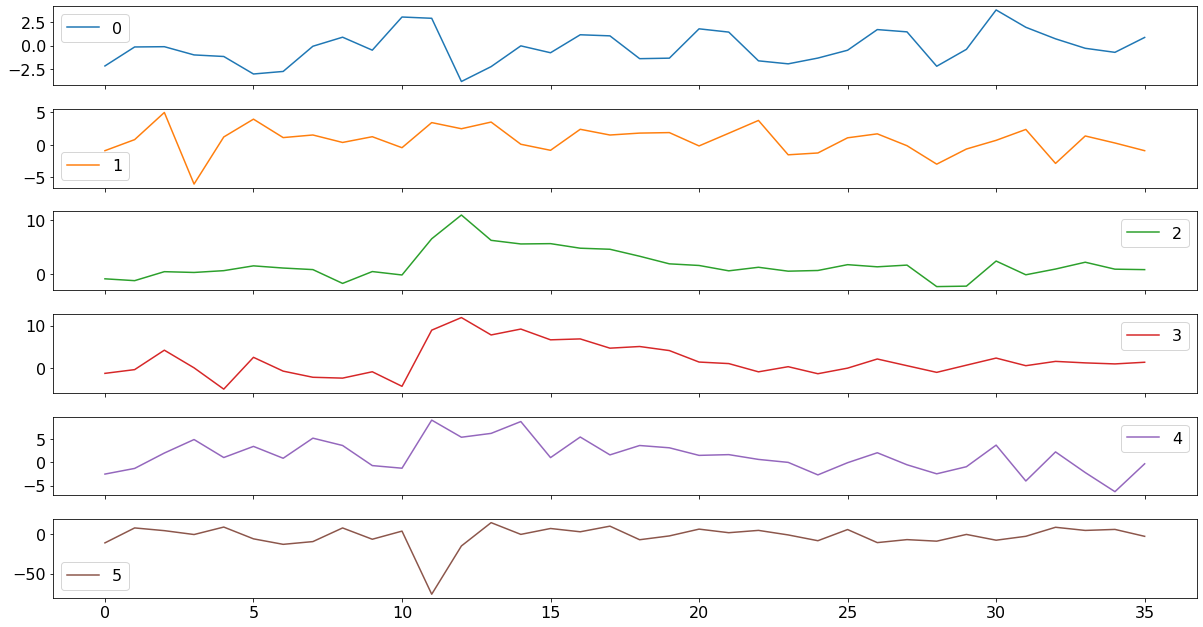

In [228]:
inspect_timewise(x_total)
inspect_multivariate(x_train, y_train)


## Model

In [229]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Preprocessing
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)
    
    # Feature extractor
    lstm = pre
    lstm = tfkl.LSTM(128, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(128)(lstm)
    lstm = tfkl.Dropout(.5, seed=seed)(lstm)
    
    # Classifier
    classifier = lstm
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [230]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Preprocessing
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)

    # Feature extractor
    bilstm = pre
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256))(bilstm)
    bilstm = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = bilstm
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [231]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    pre = input_layer
    pre = tf.keras.layers.Normalization(axis=2, name="Norm")(pre)
    

    # Feature extractor
    cnn = pre
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(pre)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    # Classifier
    classifier = cnn
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    output_layer = classifier
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [232]:
# MEH
def build_supernet_classifier(input_shape, classes):
    supernet = tfk.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        #input_shape=input_shape
    )
    
    supernet.trainable = True
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    x = tfkl.Reshape((72, 1, 3))(input_layer)
    x = tfkl.Resizing(32, 32)(x)
    # x = input_layer
    
    cnn = supernet(x)
    
    gap = tfkl.GlobalAveragePooling2D()(cnn)
    
    x = tfkl.Dropout(0.3, seed=seed)(gap)
    x = tfkl.Dense(
        256, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(0.3, seed=seed)(x)
    x = tfkl.Dense(
        256, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    classifier = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [244]:
# model = build_LSTM_classifier(input_shape, classes)
# model = build_BiLSTM_classifier(input_shape, classes)
model = build_1DCNN_classifier(input_shape, classes)   # BEST ONE
# model = build_supernet_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
Norm (Normalization)         (None, 36, 6)             13        
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 36, 128)           2432      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 18, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 9, 128)            49280 

## Training

### Adapt preprocessing layers

In [245]:
model.get_layer("Norm").adapt(x_train)

### Train

In [246]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    # class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 1s 12ms/step - loss: 2.2668 - accuracy: 0.3350 - val_loss: 2.0736 - val_accuracy: 0.3436
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 1.9654 - accuracy: 0.3690 - val_loss: 1.9636 - val_accuracy: 0.3457
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 1.8697 - accuracy: 0.3911 - val_loss: 1.8870 - val_accuracy: 0.3724
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 1.8131 - accuracy: 0.4086 - val_loss: 1.8904 - val_accuracy: 0.3621
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 1.7398 - accuracy: 0.4282 - val_loss: 1.7890 - val_accuracy: 0.3951
Epoch 6/200
31/31 [==============================] - 0s 6ms/step - loss: 1.6074 - accuracy: 0.4519 - val_loss: 1.6888 - val_accuracy: 0.4095
Epoch 7/200
31/31 [==============================] - 0s 6ms/step - loss: 1.5391 - accuracy: 0.4745 - val_loss: 1.4788 - val_accuracy: 0.5288
Epoch 8/200


## Visualize Results

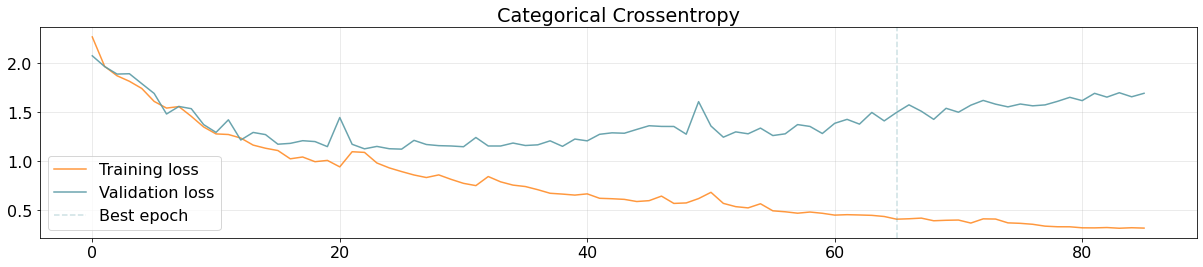

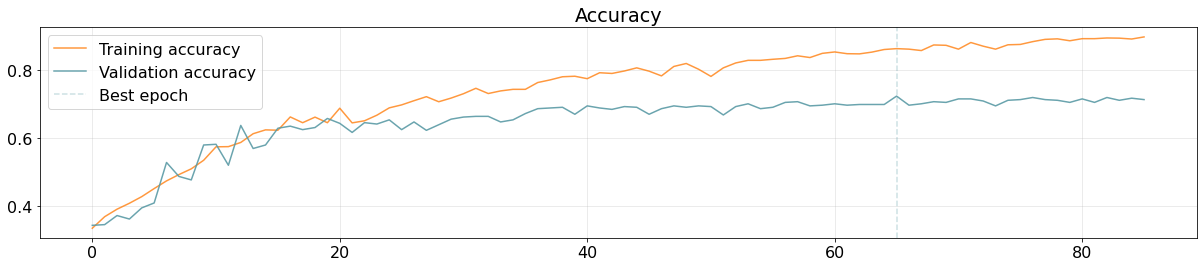

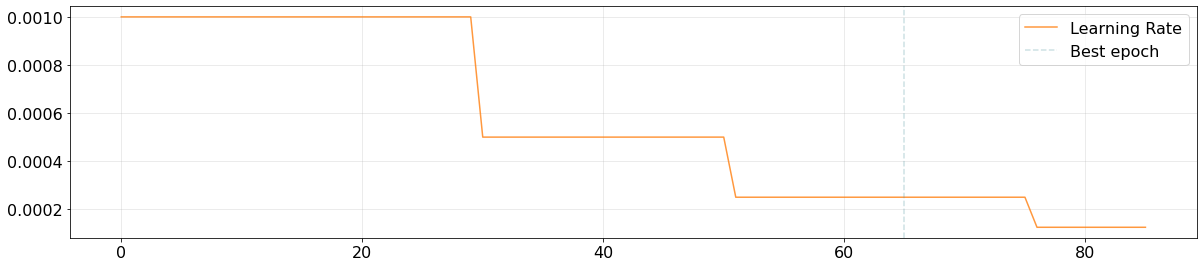

In [247]:
plot_history(history)

              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.73      0.65      0.69        34
           2       0.98      0.89      0.93        54
           3       0.51      0.55      0.53        73
           4       0.00      0.00      0.00        10
           5       0.42      0.31      0.36        32
           6       0.76      0.89      0.82        56
           7       0.50      0.25      0.33        12
           8       0.97      0.95      0.96        38
           9       0.72      0.85      0.78       144
          10       0.88      0.94      0.91        16
          11       1.00      0.12      0.22         8

    accuracy                           0.72       486
   macro avg       0.71      0.57      0.60       486
weighted avg       0.72      0.72      0.71       486

Accuracy: 0.7243
Precision: 0.7057
Recall: 0.5706
F1: 0.5953


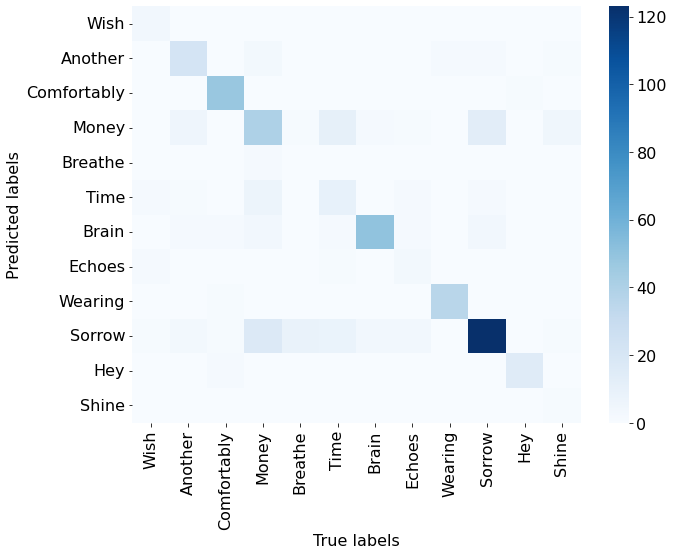

In [248]:
evaluate_classes_performance(model, x_val, y_val)

## Save

In [238]:
import shutil
model.save('ANN_Homework2_Model')
shutil.make_archive("ANN_Homework2_Model", 'zip', '/kaggle/working/ANN_Homework2_Model')

'/kaggle/working/ANN_Homework2_Model.zip'